In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import warnings
warnings.filterwarnings('ignore')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Sterling\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
dataset = 'campbell'   # 'gupta' or 'campbell' or 'campbellG'
filename = 'data/HRvsAge_samples_campbell10k.csv'

## (1) Import Samples

* ```SNID```: SDSS SNe ID
* ```Age{i}```: randomly collected from MCMC chain (Rose et al. 2019). i = 0-9999
* ```HR{i}```: artificially created normal distribution from HR_uncertainty. i = 0-9999

In [5]:
samples = pd.read_csv(filename)
samples.head(3)

,SNID,Age0,Age1,Age2,Age3,Age4,Age5,Age6,Age7,Age8,...,HR9990,HR9991,HR9992,HR9993,HR9994,HR9995,HR9996,HR9997,HR9998,HR9999
0,762,4.758532,1.558216,7.348196,4.922079,1.916873,8.067425,8.161599,3.595067,1.897597,...,0.125418,0.111031,0.049721,0.110228,0.061907,0.042606,0.070339,0.103706,0.087285,0.080275
1,1032,7.493606,10.350519,6.692530,5.663809,8.046976,3.958073,2.291889,3.648609,6.861651,...,-0.025980,-0.018704,0.003307,0.020747,-0.027311,-0.010247,-0.025592,0.028176,0.019976,-0.030866
2,1371,1.844475,9.785429,0.805218,10.507561,9.964770,9.645604,10.331896,2.330517,1.195014,...,-0.178016,-0.191690,-0.131175,-0.215081,-0.206989,-0.186684,-0.159390,-0.179546,-0.180692,-0.214565


In [6]:
num_samples = 10000 # 10k samples
length = 103
age_columns = ['Age{}'.format(i) for i in range(num_samples)]
HR_columns  = ['HR{}'.format(i) for i in range(num_samples)]

# put them together
Age_all = samples[age_columns].values.flatten()
HR_all = samples[HR_columns].values.flatten()

## (2) Make plots

### (2-1) individual

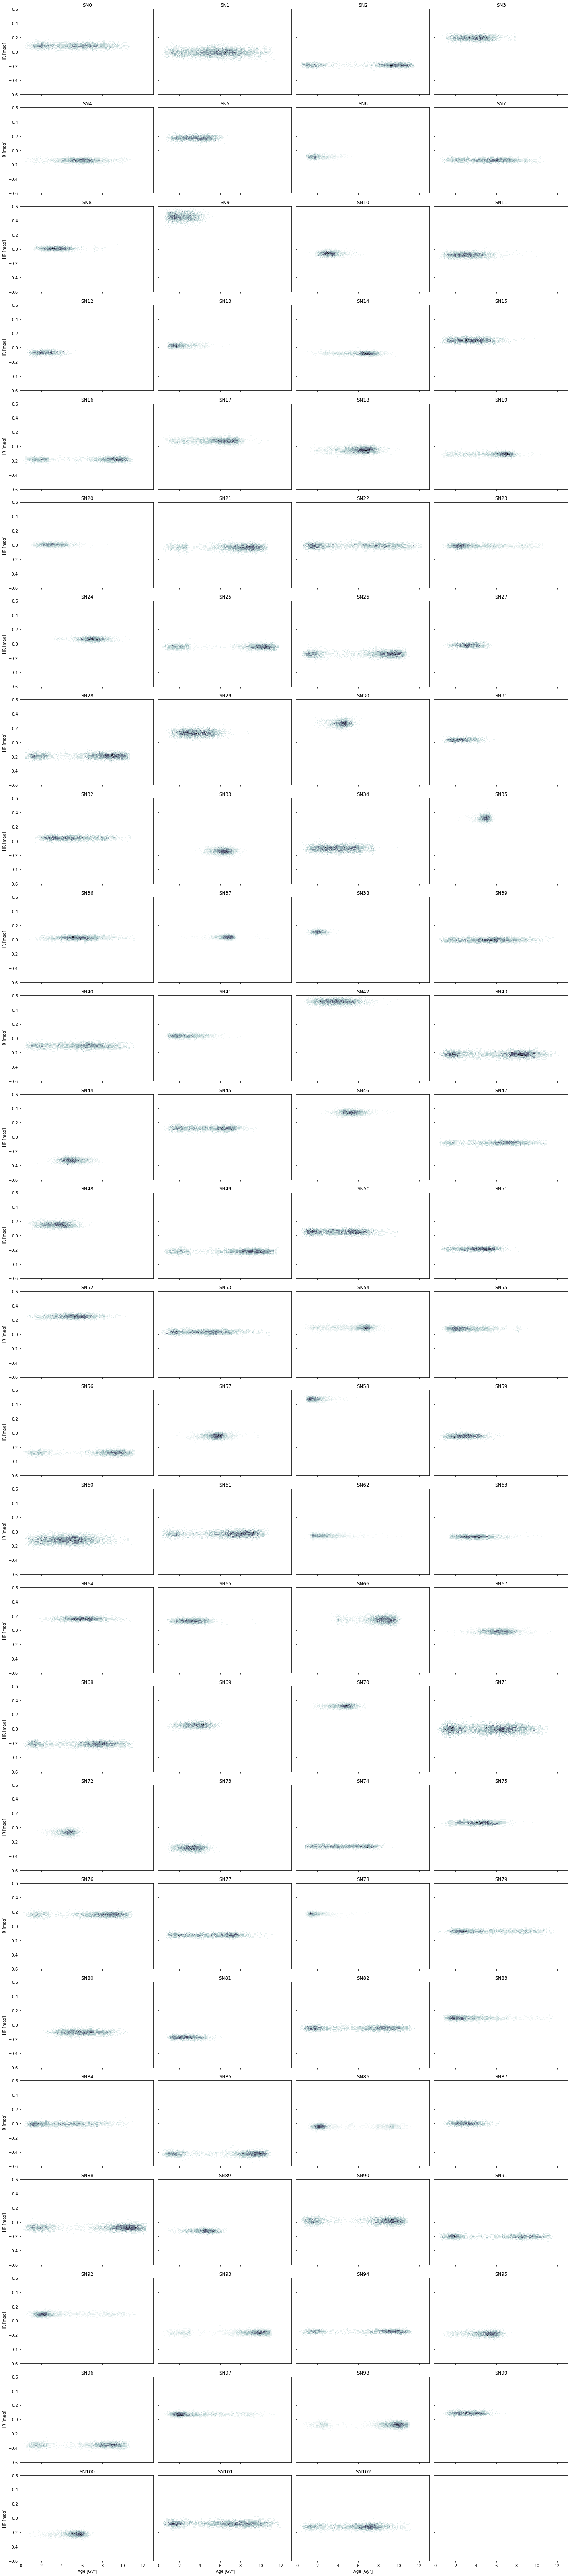

In [7]:
# plot individual
fix,axes = plt.subplots(26,4,figsize=(20,90),sharex=True,sharey=True)
for i in range(103):
    ax = axes[int(i/4)][i%4]
    SNID = samples.index.values[i]
    
    # data
    Age = samples.loc[SNID,age_columns]
    HR  = samples.loc[SNID,HR_columns]
    
    # plot
    ax.hist2d(Age,HR,bins=100,cmap='bone_r')
    ax.set_title('SN{}'.format(SNID))
    ax.set_xlim(0,13)
    ax.set_ylim(-0.6,0.6)
    if int(i/4) == 25:
        ax.set_xlabel('Age [Gyr]')
    if i%4 == 0:
        ax.set_ylabel('HR [mag]')
plt.tight_layout()
plt.savefig('figures/HRvsAge_individual_Campbell10k.pdf')

### (2-2) overall

In [23]:
np.corrcoef(stats.rankdata(Age_all, method="ordinal"), stats.rankdata(HR_all, method="ordinal"))[0, 1], stats.spearmanr(Age_all, HR_all)[0]

(-0.2117887029888756, -0.21178870291070148)

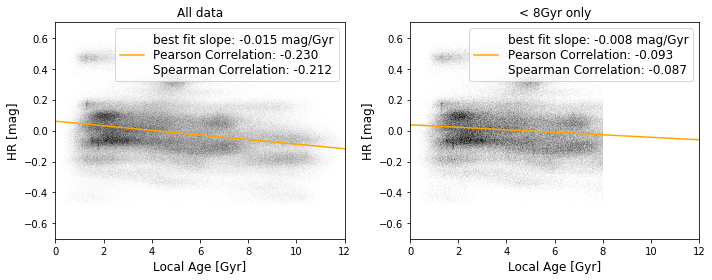

In [8]:
Nbins = 300
cmap = 'gray_r'
x_th = np.linspace(0,14,10)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

# Calculate correlations and slope for all
corr = stats.pearsonr(Age_all, HR_all)[0]
rank_corr = stats.spearmanr(Age_all, HR_all)[0]
popt,_ = curve_fit(lambda x,a,b: a*x+b, Age_all, HR_all)
y_th = x_th * popt[0] + popt[1]

ax1.plot(x_th,y_th,c='orange', label=f"best fit slope: {popt[0]:.3f} mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rank_corr:.3f}")
ax1.hist2d(Age_all, HR_all,bins=Nbins,cmap=cmap)
ax1.set_title('All data')

# Calculate correlation and slope for <8Gyr
corr = stats.pearsonr(Age_all[Age_all<8], HR_all[Age_all<8])[0]
rank_corr = stats.spearmanr(Age_all[Age_all<8], HR_all[Age_all<8])[0]
popt,_ = curve_fit(lambda x,a,b: a*x+b, Age_all[Age_all<8], HR_all[Age_all<8])
y_th = x_th * popt[0] + popt[1]

ax2.plot(x_th,y_th,c='orange', label=f"best fit slope: {popt[0]:.3f} mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rank_corr:.3f}")
ax2.hist2d(Age_all[Age_all<8], HR_all[Age_all<8],bins=Nbins,cmap=cmap)
ax2.set_title('< 8Gyr only')

for ax in [ax1,ax2]:
    ax.legend(fontsize=12)
    ax.set_xlabel('Local Age [Gyr]',fontsize=12)
    ax.set_ylabel('HR [mag]',fontsize=12)
    ax.set_xlim(0,12)
    ax.set_ylim(-0.7,0.7)
plt.tight_layout()
plt.savefig('figures/HRvsAge_overall_campbell10k.pdf')

## (3) age gap?

In [5]:
# downsample
HR_1k = HR_all[::100]
Age_1k = Age_all[::100]

### no-slope model

In [42]:
# no-slope model
with pm.Model() as model:
    b1 = pm.Normal('b1',0,0.01)
    b2 = pm.Normal('b2',0,0.01)
    c = pm.Uniform('c',lower=np.min(Age_1k),upper=np.max(Age_1k))
    sigma = pm.Normal('sigma',0.1,1)
    
    model = pm.math.switch((Age_1k<c), b1, b2)
    likelihood = pm.Normal('likelihood',model,sigma,observed=HR_1k)
    
    step = pm.Slice()
    trace0 = pm.sample(4000,tune=2000,step=step,
                      idata_kwargs={'log_likelihood':False})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [c]
>Slice: [b2]
>Slice: [b1]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 31 seconds.


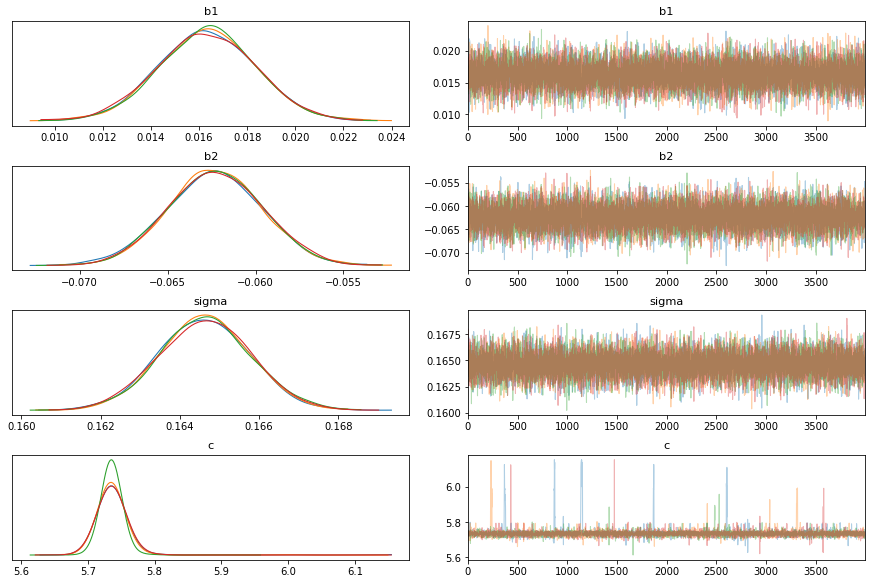

In [43]:
az.plot_trace(trace0);
summary0 = az.summary(trace0,round_to=3)

### single-slope model

In [23]:
with pm.Model() as model:
    a = pm.Normal('a',0,0.01)
    b1 = pm.Normal('b1',0,0.01)
    b2 = pm.Normal('b2',0,0.01)
    c = pm.Uniform('c',lower=np.min(Age_1k),upper=np.max(Age_1k))
    sigma = pm.Normal('sigma',0.1,1)
    
    model = pm.math.switch((Age_1k<c), a*Age_1k+b1, a*Age_1k+b2)
    likelihood = pm.Normal('likelihood',model,sigma,observed=HR_1k)
    
    step = pm.Slice()
    trace = pm.sample(4000,tune=2000,step=step,
                      idata_kwargs={'log_likelihood':False})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [c]
>Slice: [b2]
>Slice: [b1]
>Slice: [a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 35 seconds.
The number of effective samples is smaller than 10% for some parameters.


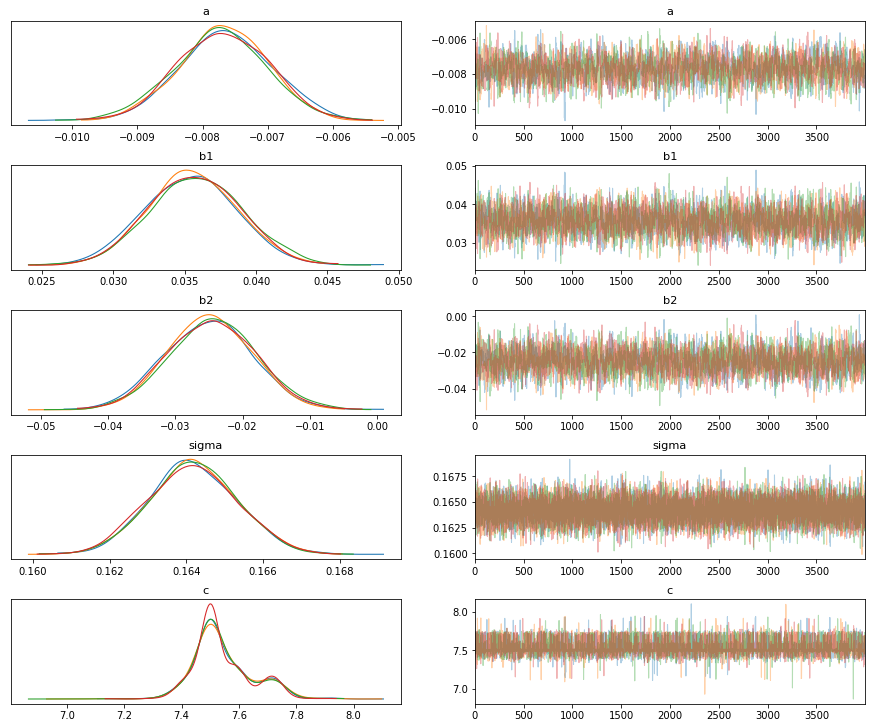

In [25]:
az.plot_trace(trace);
summary1 = az.summary(trace,round_to=3)

### double-slope model

In [27]:
with pm.Model() as model2:
    a1 = pm.Normal('a1',0,0.01)
    a2 = pm.Normal('a2',0,0.01)
    b1 = pm.Normal('b1',0,0.01)
    b2 = pm.Normal('b2',0,0.01)
    c = pm.Uniform('c',lower=np.min(Age_1k),upper=np.max(Age_1k))
    sigma = pm.Normal('sigma',0.1,1)
    
    model = pm.math.switch((Age_1k<c), a1*Age_1k+b1, a2*Age_1k+b2)
    likelihood = pm.Normal('likelihood',model,sigma,observed=HR_1k)
    
    step = pm.Slice()
    trace2 = pm.sample(4000,tune=2000,step=step,
                      idata_kwargs={'log_likelihood':False})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [c]
>Slice: [b2]
>Slice: [b1]
>Slice: [a2]
>Slice: [a1]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 43 seconds.
The number of effective samples is smaller than 10% for some parameters.


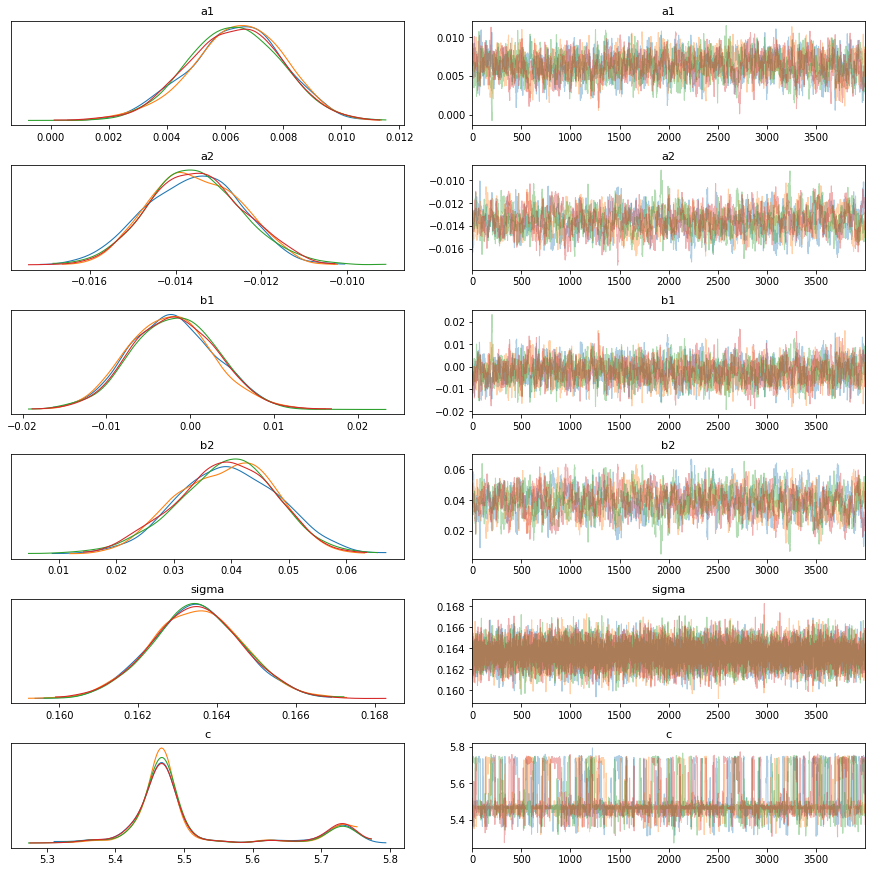

In [28]:
az.plot_trace(trace2);
summary2 = az.summary(trace2,round_to=3)

### plot

In [52]:
# no-slope model
b1_0 = summary0.loc['b1','mean']
b2_0 = summary0.loc['b2','mean']
c0 = summary0.loc['c','mean']

x0 = np.linspace(0,c0,10)
x01 = np.linspace(c0,13,10)
y0 = np.full(x0.shape,b1_0)
y01 = np.full(x01.shape,b2_0)

In [38]:
# single-slope model
a0 = summary1.loc['a','mean']
b1_1 = summary1.loc['b1','mean']
b2_1 = summary1.loc['b2','mean']
c1 = summary1.loc['c','mean']

x1 = np.linspace(0,c1,10)
x2 = np.linspace(c1,13,10)
y1 = a0*x1+b1_1
y2 = a0*x2+b2_1

In [39]:
# double-slope model
a1 = summary2.loc['a1','mean']
a2 = summary2.loc['a2','mean']
b1_2 = summary2.loc['b1','mean']
b2_2 = summary2.loc['b2','mean']
c2 = summary2.loc['c','mean']

x3 = np.linspace(0,c2,10)
x4 = np.linspace(c2,13,10)
y3 = a1*x3+b1_2
y4 = a2*x4+b2_2

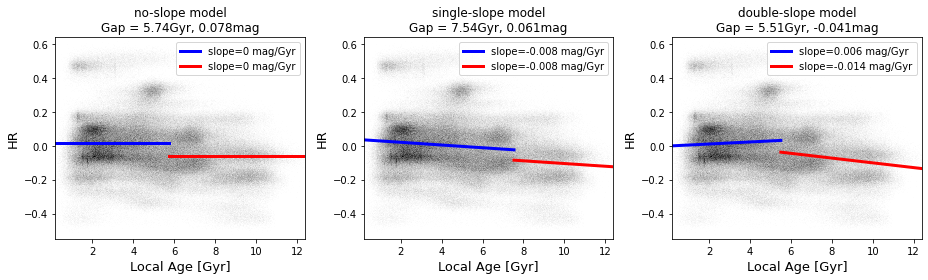

In [60]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.hist2d(Age_all,HR_all,bins=300,cmap='gray_r')
ax1.plot(x0,y0,c='b',lw=3,label=f'slope=0 mag/Gyr')
ax1.plot(x01,y01,c='r',lw=3,label=f'slope=0 mag/Gyr')
ax1.set_title(f'no-slope model\nGap = {c0:.2f}Gyr, {(b1_0-b2_0):.3f}mag')
ax1.set_xlabel('Local Age [Gyr]',fontsize=13)
ax1.set_ylabel('HR',fontsize=13)
ax1.legend()


ax2.hist2d(Age_all,HR_all,bins=300,cmap='gray_r')
ax2.plot(x1,y1,c='b',lw=3,label=f'slope={a0:.3f} mag/Gyr')
ax2.plot(x2,y2,c='r',lw=3,label=f'slope={a0:.3f} mag/Gyr')
ax2.set_title(f'single-slope model\nGap = {c1:.2f}Gyr, {(b1_1-b2_1):.3f}mag')
ax2.set_xlabel('Local Age [Gyr]',fontsize=13)
ax2.set_ylabel('HR',fontsize=13)
ax2.legend()

ax3.hist2d(Age_all,HR_all,bins=300,cmap='gray_r')
ax3.plot(x3,y3,c='b',lw=3,label=f'slope={a1:.3f} mag/Gyr')
ax3.plot(x4,y4,c='r',lw=3,label=f'slope={a2:.3f} mag/Gyr')
ax3.set_title(f'double-slope model\nGap = {c2:.2f}Gyr, {(b1_2-b2_2):.3f}mag')
ax3.set_xlabel('Local Age [Gyr]',fontsize=13)
ax3.set_ylabel('HR',fontsize=13)
ax3.legend()
plt.tight_layout()
plt.savefig('age_gap_campbell_local.pdf')

## (4) Stats

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between ```Age_all``` and ```HR_all```.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a correlation, but it is not strong enough to deny dark energy
    4. there is a strong correlation, but slope is not large enough to deny dark energy
    5. there is a strong correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

### (4-1) Reproduce Rose19's plots

In [61]:
## global v local labels
if dataset in ['gupta', 'campbellG']:
    xlabel = 'global age [Gyr]'
else:
    xlabel = 'local age [Gyr]'

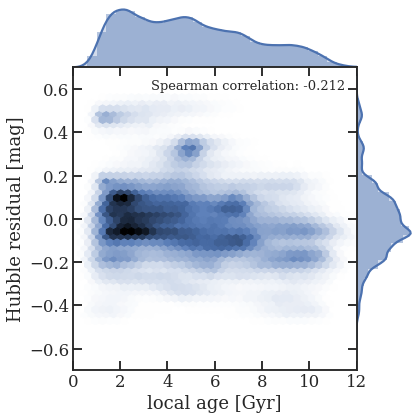

In [62]:
# similar to https://github.com/benjaminrose/MC-Age/blob/master/figures/Results-HRvsAge-redshiftcut.ipynb
sns.set(context='talk', style='ticks', font='serif', color_codes=True)
g = sns.jointplot(Age_all, HR_all, stat_func=stats.spearmanr,
                  kind="hex", gridsize=40,
                  bins=None, space=0.0, xlim=(0,12),  ylim=(-0.7, 0.7),
                  marginal_kws={'bins':30, 'kde':True, 'hist':True,
                                'kde_kws':{"shade":True},'hist_kws':{'linewidth': 0}})
g.ax_joint.tick_params(axis='both', direction='in')
g.ax_joint.set_axisbelow(False)
g.ax_joint.set_xticks([0, 2, 4, 6, 8, 10, 12])
g = g.annotate(stats.spearmanr, stat="Spearman correlation",
               loc="upper right", fontsize=13, 
               template="{stat}: {val:.3f}",
               frameon=False)
g = g.set_axis_labels(xlabel, 'Hubble residual [mag]')
plt.show()